In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import seaborn as sns

sys.path.append('..')
sys.path.append('../../..')
sys.path.append('../../../lib/trim')
sys.path.append('../../../src')
sys.path.append('../../../src/vae')
sys.path.append('../../../src/dsets/gaussian_mixture')

from src.vae.model import init_specific_model
import src.viz as viz
from src.vae.utils import *
from src.vae.utils import plot_2d_samples, plot_2d_latent_samples, plot_traversals
from sim_gaussian_mixture import p, define_dataloaders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#     out_dir = "/home/ubuntu/local-vae/notebooks/ex_gaussian_mixture/results" # wooseok's setup
out_dir_main = '/scratch/users/vision/chandan/local-vae' # chandan's setup
dirs = print(os.listdir(out_dir_main))
dirs = ['vary_lamNN', 'vary_lamH', 'vary_lamNN_lamSP']

['vary_lamNN_lamSP', 'vary_lamNN', 'vary_lamH']


In [4]:
# dirs = ["vary_lamPT_beta_warmstart_seed=15"]
results = []
models = []
for i in tqdm(range(len(dirs))):
    # load results
    out_dir = opj(out_dir_main, dirs[i])
    fnames = sorted(os.listdir(out_dir))

    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            model = init_specific_model(orig_dim=results_list[-1]['orig_dim'], 
                                        latent_dim=results_list[-1]['latent_dim'], 
                                        hidden_dim=results_list[-1]['hidden_dim']).to(device)
            model.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(model)
            
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

100%|██████████| 3/3 [00:06<00:00,  2.82s/it]


## Plotting results

In [5]:
# pick what to be plotting
r = results[2] # results[1] # results[1]
vary_var = 'lamNN' # 'lamH' # ['lamNN', 'lamH']


hue = 'lamSP' # can subplot by something
ys = ['disentanglement_metric', 'reconstruction_loss',
      'kl_normal_loss',
      'pt_local_independence_loss', 'hessian_loss']

In [ ]:
R, C = 3, 2
plt.figure(figsize=(8, 13))
for i, y in enumerate(ys):
    plt.subplot(R, C, i + 1)
    ax = sns.pointplot(x=vary_var, y=y,
                       hue=hue, data=r)
    plt.grid()
plt.tight_layout()
viz.save_fig(vary_var + '_basics')

## Visualize the directions of the model which disentangles the best

disentanglement metric: 0.312


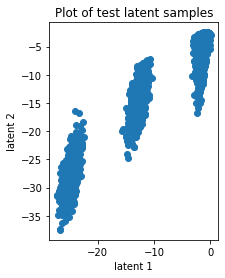

In [7]:
# GET MODEL AND RESULT
idx = np.argmin(np.array(r['disentanglement_metric']))
model = models[0][idx]
result = r.loc[idx]
print(f'disentanglement metric: {result["disentanglement_metric"]:.3f}')

params_to_vary = ['num_epochs', 'seed', 'hidden_dim', 'beta', 'mu', 'lamPT',
                  'lamCI', 'dirname', 'latent_means', 'latent_vars']
for name in params_to_vary:
    setattr(p, name, result[name])
    
# SEED
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)    

# GET DATALOADERS
(_, _), (test_loader, test_latents) = define_dataloaders(p)

# EVALUATE TEST DATA
data = test_loader.dataset.data.to(device)
recon_data, latent_dist, latent_sample = model(data)
plot_2d_latent_samples(latent_sample)
plt.xlabel('latent 1')
plt.ylabel('latent 2')
plt.title("Plot of test latent samples")
viz.save_fig(vary_var + '_reconstructions')

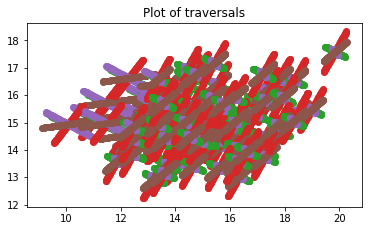

In [23]:
plot_traversals(model, data, lb=1000, ub=2000, num=100, max_traversal=.5)
plt.title("Plot of traversals")
viz.save_fig(vary_var + '_traversals')

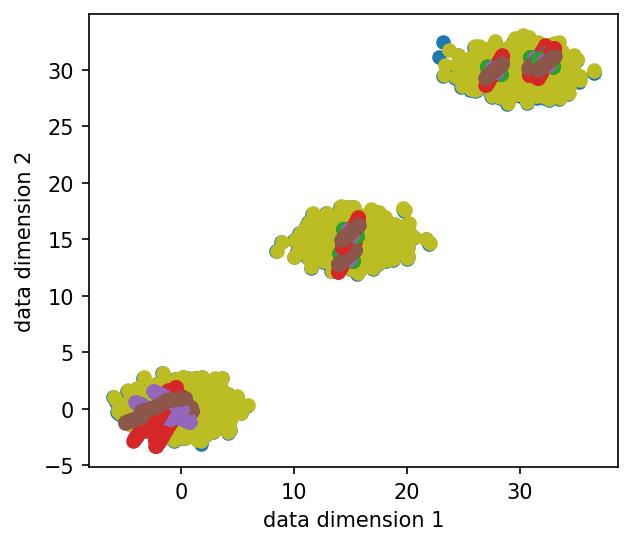

In [24]:
plt.figure(dpi=150)
plot_traversals(model, data, lb=0, ub=3000, num=10,
                draw_data=True, draw_recon=True, max_traversal=.9)
plt.xlabel('data dimension 1')
plt.ylabel('data dimension 2')
viz.save_fig(vary_var + '_directions')